In [51]:

#pip install nltk

In [52]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download ('wordnet')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import re


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

cwd = os.getcwd()
df = pd.read_csv(cwd + '/raw_data/chatgpt-reddit-comments.csv')
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


<AxesSubplot:>

Text(0.5, 0, 'Sub-Reddit')

Text(0, 0.5, 'Number of Comments')

Text(0.5, 1.0, 'Sub-Reddit Distribution')

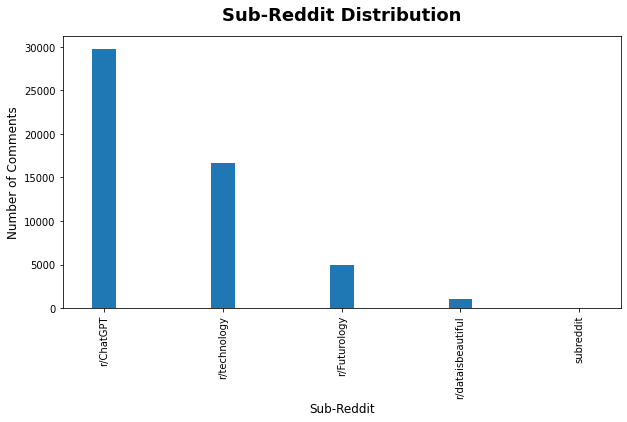

In [54]:
df['subreddit'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2)

plt.xlabel("Sub-Reddit", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Sub-Reddit Distribution", fontsize=18,pad=16, fontweight="bold")

plt.show()

In [55]:
#Check for/Remove NULL values
df.dropna(inplace=True)
df.isnull().value_counts()
df.head()

Unnamed: 0  comment_id  comment_parent_id  comment_body  subreddit
False       False       False              False         False        52412
dtype: int64

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [56]:
stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
def clean_comments(comment):
    #Normalize text
    comment = comment.lower()

    #Remove special characters/URLS and '@' tags and non numbers/letters
    comment = re.sub(r"(@\[A-Za-z0-9]+)|([^A-Za-z])|(\w+:\/\/\S+)|^rt|http.+?", " ", comment)

    #Remove linebreaks
    comment = re.sub(r"\n", " ",comment)
    
    #Remove non-words/single characters
    comment = re.sub(r"(^| ).(( ).)*( |$)", " ", comment)

    #Remove stopwords and lemmatize
    word_tokens = word_tokenize(comment)
    clean_token_list = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            clean_token_list.append(lemmatizer.lemmatize(word_token,pos = 'v'))
    
    clean_comment = " ".join(clean_token_list)
    
    return clean_comment


In [57]:
cleaned_df = pd.read_csv(cwd + '\processed\clustered_comments.csv')
cleaned_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,cluster
0,0,0,0,iztdxuh,t3_zj2aeu,shock days need clickbait,r/ChatGPT,2
1,1,1,1,iztn0q0,t3_zj2aeu,angry right waste time read post sub clickbait...,r/ChatGPT,0
2,2,2,2,izudrph,t3_zj2aeu,chatgpt karma whore folks think stream think b...,r/ChatGPT,0
3,3,3,3,iztfhtb,t3_zj2aeu,work ngl,r/ChatGPT,0
4,4,4,4,izu2as9,t3_zj2aeu,certify must see moment really shock core,r/ChatGPT,2


In [58]:
# Generating TF-IDF Vector for KMeans from the comment_body
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                ngram_range = (1,3),
                                stop_words = "english"                              
                            )

tf_idf = vectorizer.fit_transform(cleaned_df.comment_body)

In [59]:
#Sample of 50 words for the TFIDF dictionary
from sklearn.pipeline import islice
dict(islice(vectorizer.vocabulary_.items(), 0,50))

{'shock': 977079,
 'days': 276309,
 'need': 710908,
 'clickbait': 192678,
 'shock days': 977116,
 'days need': 276677,
 'need clickbait': 711728,
 'shock days need': 977117,
 'days need clickbait': 276678,
 'angry': 51721,
 'right': 924516,
 'waste': 1196942,
 'time': 1108265,
 'read': 872873,
 'post': 812235,
 'sub': 1042884,
 'title': 1114801,
 'chatgpt': 168200,
 'believe': 105568,
 'machine': 643197,
 'learn': 589165,
 'model': 691012,
 'able': 1568,
 'trick': 1130828,
 'think': 1096217,
 'actually': 15118,
 'bunch': 139074,
 'meaningless': 672839,
 'garbage': 430521,
 'sick': 979338,
 'tire': 1114580,
 'ability': 564,
 'generate': 433498,
 'fake': 384714,
 'content': 233759,
 'design': 291191,
 'people': 773276,
 'click': 192368,
 'fool': 410001,
 'sure': 1053449,
 'stand': 1018857,
 'anymore': 57623,
 'demand': 287064,
 'moderators': 694644,
 'action': 12879,
 'creators': 258796,
 'stop': 1028290,
 'trickery': 1131222,
 'hold': 490822,
 'accountable': 10099}

In [60]:
param = range(1,5)
sse = []
for k in param:
    model = KMeans(n_clusters= k, init="k-means++", random_state=10, max_iter=100, n_init=1)
    model.fit(tf_idf)
    sse.append(model.inertia_)

KMeans(max_iter=100, n_clusters=1, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=2, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=3, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=10)

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Sum of Squared Error')

Text(0.5, 1.0, 'Elbow plot')

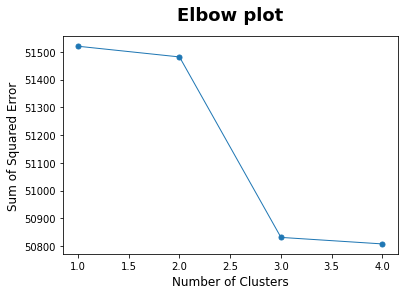

In [68]:
#Visual for the Elbow method for determining optimal K value
plt.plot(param, sse, marker = '.', markersize=10, linewidth = 1)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Sum of Squared Error", fontsize=12)
plt.title("Elbow plot", fontsize=18,pad=16, fontweight="bold")

In [62]:
#List 20 words whose TF_IDF vector representation is closest to respective centers
optimal_k = 3
print("Cluster Centers")
centers = model.cluster_centers_.argsort()[:, ::-1]
center_words = vectorizer.get_feature_names()

for i in range(optimal_k):
    print(f"Cluster {i}")
    for j in centers[i, :20]:
        print(f"{center_words[j]}")

Cluster Centers


C:\Users\erice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0
delete
delete delete
delete delete delete
zzs
free plan
free pick
free pick pineapples
free place
free place sweet
free plagiarism
free plagiarism checker
free plane
free plan allow
free phrase like
free plane ticket
free play
free play chat
free playground
free pls
free phrase likely
Cluster 1
write
use
chatgpt
prompt
essay
use chatgpt
code
ask
like
work
make
ai
gpt
comment
tool
students
chatgpt write
help
time
bot
Cluster 2
work
like
make
people
lol
think
know
thank
say
good
try
time
mean
need
remove
pay
want
right
really
use


<AxesSubplot:>

Text(0.5, 0, 'Cluster Label')

Text(0, 0.5, 'Number of Comments')

Text(0.5, 1.0, 'Cluster Data Frequency')

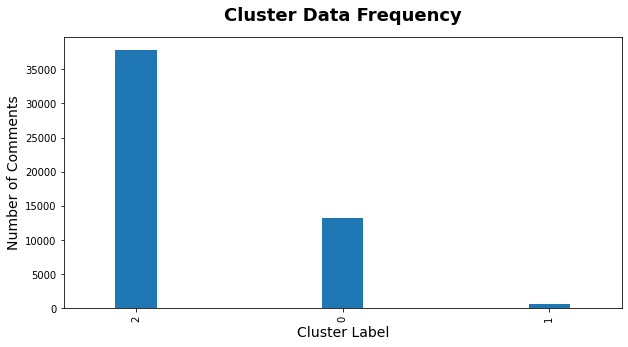

In [67]:
cleaned_df['cluster'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2)

plt.xlabel("Cluster Label", fontsize=14)
plt.ylabel("Number of Comments", fontsize=14)
plt.title("Cluster Data Frequency", fontsize=18,pad=16, fontweight="bold" )

plt.show()

In [64]:
## Creating Vader object for Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

analyser = SentimentIntensityAnalyzer()

In [101]:
cleaned_df['vader_score'] = cleaned_df.comment_body.apply(lambda x: analyser.polarity_scores(x)['compound'])
cleaned_df['sentiment'] = cleaned_df.vader_score.apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x<-0.05 else 'Neutral'))

<AxesSubplot:xlabel='cluster', ylabel='count'>

<AxesSubplot:xlabel='cluster', ylabel='count'>

<AxesSubplot:xlabel='cluster', ylabel='count'>

Text(0.5, 1.0, 'Positive Score')

Text(0.5, 1.0, 'Neutral Score')

Text(0.5, 1.0, 'Negative Score')

Text(0.5, 0, 'Clusters')

Text(0.5, 0, 'Clusters')

Text(0.5, 0, 'Clusters')

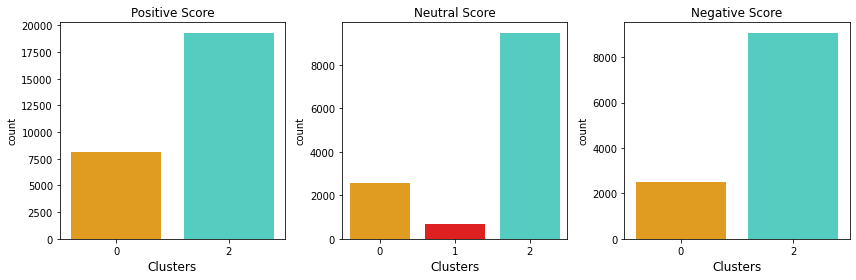

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
cols = ['red' if x == 0 else 'green' if x == 1 else 'blue' for x in cleaned_df.cluster]
sns.countplot(data=cleaned_df[cleaned_df['sentiment']=='Positive'], x='cluster', ax=axs[0], palette = ['orange','turquoise'])
sns.countplot(data=cleaned_df[cleaned_df['sentiment']=='Neutral'], x='cluster', ax=axs[1],palette = ['orange','red','turquoise'] )
sns.countplot(data =cleaned_df[cleaned_df['sentiment']=='Negative'], x='cluster', ax=axs[2],palette = ['orange','turquoise'])


axs[0].set_title("Positive Score", fontsize=12)
axs[1].set_title("Neutral Score", fontsize=12)
axs[2].set_title("Negative Score", fontsize=12)

axs[0].set_xlabel("Clusters", fontsize=12)
axs[1].set_xlabel("Clusters", fontsize=12)
axs[2].set_xlabel("Clusters", fontsize=12)


plt.tight_layout()
plt.show()


In [88]:

cols[cleaned_df[(cleaned_df['sentiment']=='Positive')].index]

TypeError: list indices must be integers or slices, not Int64Index